In [1]:
import pandas as pd
import numpy as np
import cv2  # for image processing
import scipy.io
import os
from arts_preprocess_utils import load_dataset, get_image
import scipy
#from scipy.spatial.distance import directed_hausdorff, cosine
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def colum_distribution(df, col):
    df_col = df.groupby(col)[col].count()
    return df_col

## Load Data

In [3]:
#Artwork metadata

df_artworks = pd.read_csv('/root/work/datasets/train_mayors_style_encoded.csv')
df_artworks = df_artworks[['filename', 'title', 'style', 'genre']]
df_artworks.head()

,filename,title,style,genre
0,70944.jpg,Forbidden Land,Surrealism,landscape
1,99442.jpg,Storm at sea,Romanticism,marina
2,28908.jpg,Yachting in the Mediterranean,Realism,genre painting
3,7486.jpg,Death of Eleazer,Romanticism,religious painting
4,35766.jpg,The-Deluge,Romanticism,religious painting


In [4]:
df_sample = df_artworks.sample(n=10000)

In [5]:
#Artwork codes

artwork_vgg19_code_matrix = np.load('/root/work/datasets/train_mayors_style_encoded_vgg19.npy')
artwork_code_matrix = np.load('/root/work/datasets/train_mayors_style_encode.npy')
artwork_w_code_matrix = np.load('/root/work/datasets/train_mayors_style_w_encoded.npy')
artwork_code_matrix.shape

(46010, 300)

In [6]:
#Take the sample

artwork_vgg19_code_matrix_sample = np.take(artwork_vgg19_code_matrix, df_sample.index, axis=0)
artwork_code_matrix_sample = np.take(artwork_code_matrix, df_sample.index, axis=0)
artwork_w_code_matrix_sample = np.take(artwork_w_code_matrix, df_sample.index, axis=0)
artwork_vgg19_code_matrix_sample.shape

(10000, 32768)

### Style distribution

Check if the sample is good represantition of the population

In [7]:
df_style = colum_distribution(df=df_artworks, col='style')
df_style_sample = colum_distribution(df=df_sample, col='style')
df_style

style
Art Nouveau (Modern)    3778
Baroque                 3252
Expressionism           5325
Impressionism           8220
Post-Impressionism      4527
Realism                 8109
Romanticism             7040
Surrealism              3133
Symbolism               2626
Name: style, dtype: int64

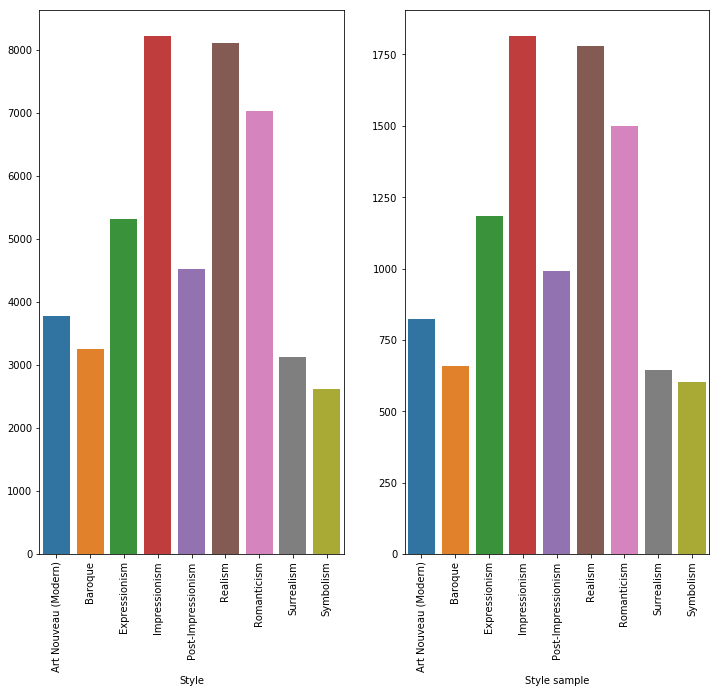

In [8]:
fig, ax =plt.subplots(1,2, figsize=(12,10))
g_total = sns.barplot(x=df_style.index, y=df_style.values, ax=ax[0])
g_total.set_xticklabels(g_total.get_xticklabels(), rotation=90)
g_total.set(xlabel='Style')
g_sample = sns.barplot(x=df_style_sample.index, y=df_style_sample.values, ax=ax[1])
g_sample.set_xticklabels(g_sample.get_xticklabels(), rotation=90)
g_sample.set(xlabel='Style sample')

### TSNE distribution

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
tsne = TSNE(n_components=2, perplexity=10, n_iter=500)

Reduce dimensions to plot TSNE distribution. Because some approaches are high dimensional, first we do an approximation using PCA and the apply TSNE.

In [10]:
from sklearn.pipeline import Pipeline

pca_tsne = Pipeline([
    ('pca', pca),
    ('tsne', tsne)])

In [11]:
tsne_result = pca_tsne.fit_transform(artwork_code_matrix_sample)
tsne_result_w = tsne.fit_transform(artwork_w_code_matrix_sample)
tsne_result_vgg19 = pca_tsne.fit_transform(artwork_vgg19_code_matrix_sample)

In [12]:
df_sample['tsne-x'] = tsne_result[:,0]
df_sample['tsne-y'] = tsne_result[:,1]
df_sample['w-tsne-x'] = tsne_result_w[:,0]
df_sample['w-tsne-y'] = tsne_result_w[:,1]
df_sample['vgg19-tsne-x'] = tsne_result_vgg19[:,0]
df_sample['vgg19-tsne-y'] = tsne_result_vgg19[:,1]

df_sample.head()

,filename,title,style,genre,tsne-x,tsne-y,w-tsne-x,w-tsne-y,vgg19-tsne-x,vgg19-tsne-y
23028,76704.jpg,On the Lakeshore,Symbolism,symbolic painting,3.137553,4.503509,4.093376,2.069883,-1.245791,8.888570
39770,84877.jpg,Haunted House,Expressionism,interior,0.878711,2.902525,-1.978695,-1.885811,-1.759624,-0.970232
17322,8857.jpg,Peasants in an Interior,Baroque,genre painting,-6.582310,4.298981,1.373780,2.274256,2.403154,-0.272295
33467,74745.jpg,Song of the Slaves,Art Nouveau (Modern),genre painting,6.469925,1.722044,-2.155070,-1.863438,-3.102667,2.088468
5049,36308.jpg,Untitled,Surrealism,symbolic painting,-3.881007,-4.296725,-0.692076,2.265487,0.989361,7.258765


### Plot distribution

**Plot all together**

Do not look nice yet. But it is useful to see all data in one plot

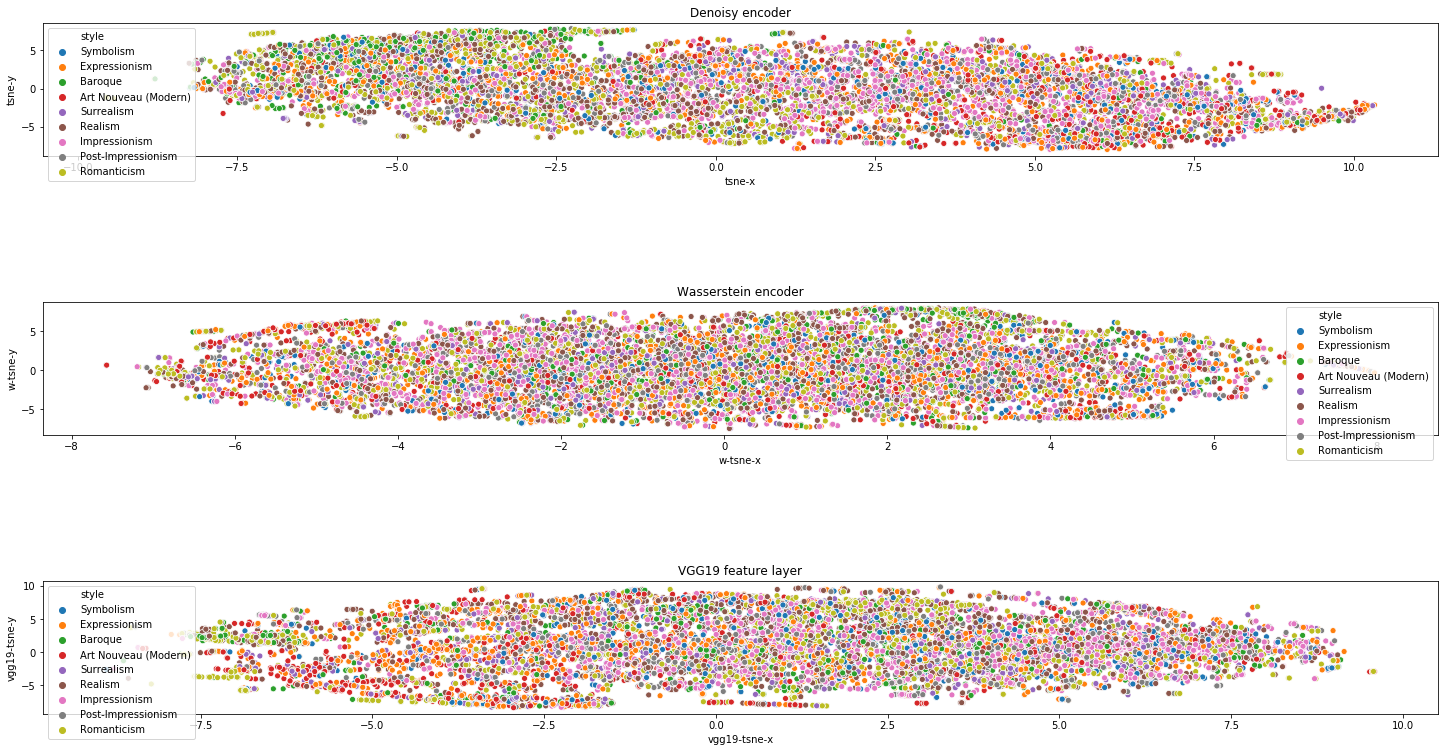

In [23]:
fig, ax =plt.subplots(3,1, figsize=(25,12))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
sns.scatterplot(x='tsne-x', y='tsne-y', hue='style', data=df_sample, ax=ax[0]).set_title('Denoisy encoder')
sns.scatterplot(x='w-tsne-x', y='w-tsne-y', hue='style', data=df_sample, ax=ax[1]).set_title('Wasserstein encoder')
sns.scatterplot(x='vgg19-tsne-x', y='vgg19-tsne-y', hue='style', data=df_sample, ax=ax[2]).set_title('VGG19 feature layer')

In [24]:
fig.savefig('./image_result/tsne-analysis-together.jpg')

**Plot indivudually**

Look better

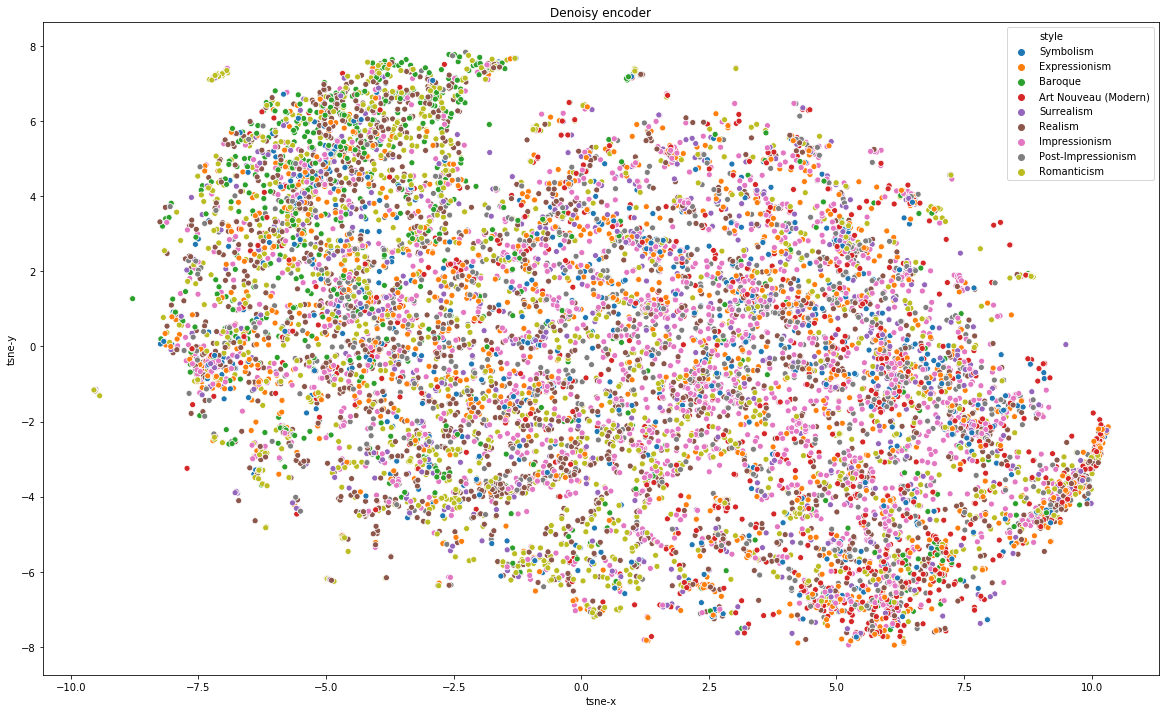

In [15]:
fig = plt.figure(figsize=(20,12))
sns.scatterplot(x='tsne-x', y='tsne-y', hue='style', data=df_sample).set_title('Denoisy encoder')

In [16]:
fig.savefig('./image_result/tsne-analysis-denoisy.jpg')

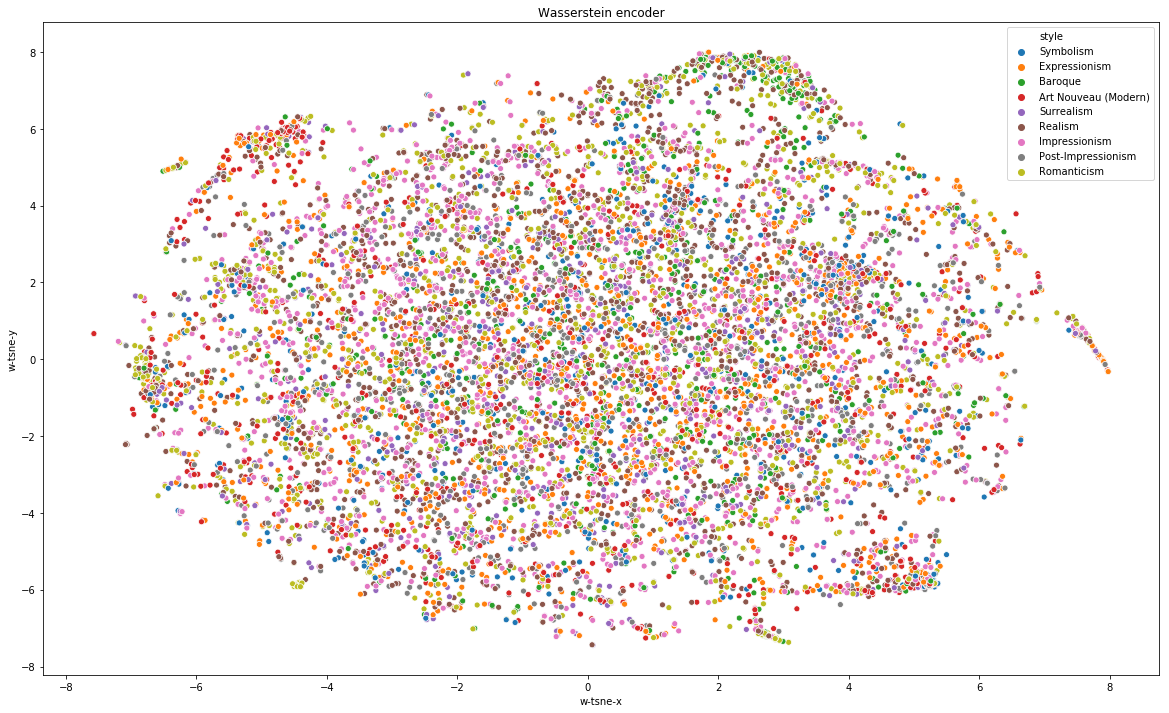

In [17]:
fig = plt.figure(figsize=(20,12))
sns.scatterplot(x='w-tsne-x', y='w-tsne-y', hue='style', data=df_sample).set_title('Wasserstein encoder')

In [18]:
fig.savefig('./image_result/tsne-analysis-wasserstein.jpg')

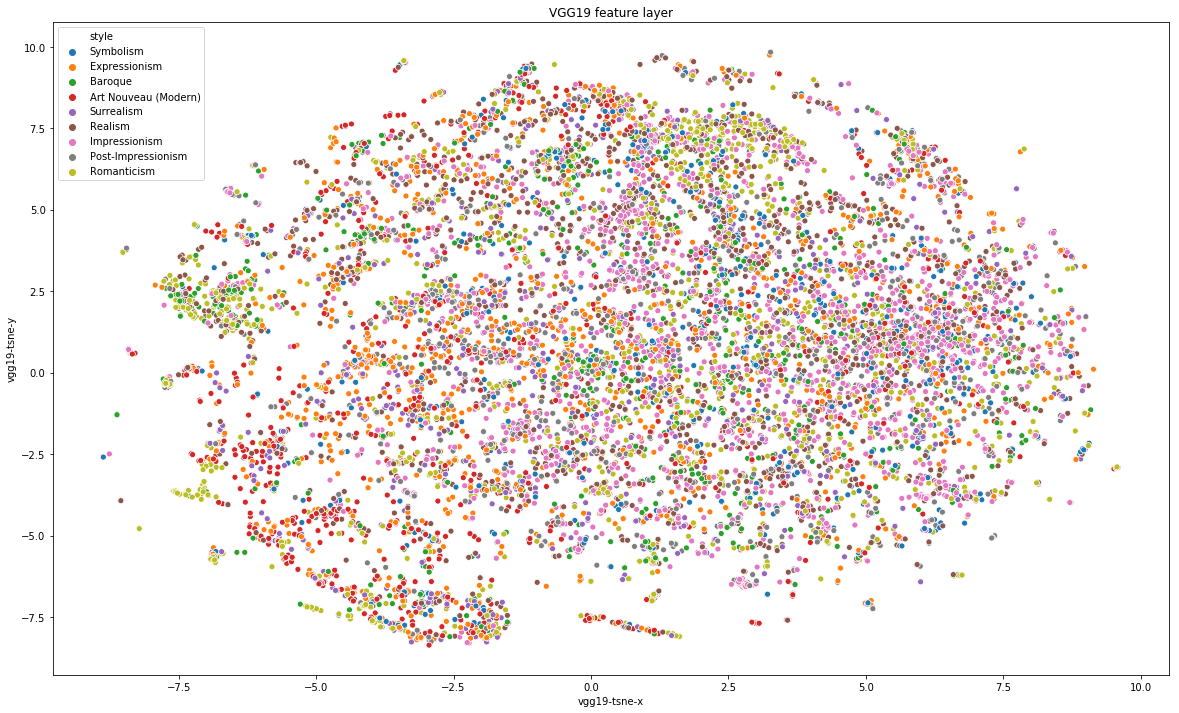

In [21]:
fig = plt.figure(figsize=(20,12))
sns.scatterplot(x='vgg19-tsne-x', y='vgg19-tsne-y', hue='style', data=df_sample).set_title('VGG19 feature layer')

In [22]:
fig.savefig('./image_result/tsne-analysis-vgg19.jpg')